In [1]:
from pathlib import Path
import torch
import torch.nn as nn
from config import get_config, get_weights_file_path
from train import get_model, get_ds, run_validation, causal_mask
import os

In [2]:
from get_accuracy import *
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
def beam_search_decode(model, beam_size, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_initial_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    # Create a candidate list
    candidates = [(decoder_initial_input, 1)]

    while True:

        # If a candidate has reached the maximum length, it means we have run the decoding for at least max_len iterations, so stop the search
        if any([cand.size(1) == max_len for cand, _ in candidates]):
            break

        # Create a new list of candidates
        new_candidates = []

        for candidate, score in candidates:

            # Do not expand candidates that have reached the eos token
            if candidate[0][-1].item() == eos_idx:
                continue

            # Build the candidate's mask
            candidate_mask = causal_mask(candidate.size(1)).type_as(source_mask).to(device)
            # calculate output
            out = model.decode(encoder_output, source_mask, candidate, candidate_mask)
            # get next token probabilities
            prob = model.project(out[:, -1])
            # get the top k candidates
            topk_prob, topk_idx = torch.topk(prob, beam_size, dim=1)
            for i in range(beam_size):
                # for each of the top k candidates, get the token and its probability
                token = topk_idx[0][i].unsqueeze(0).unsqueeze(0)
                token_prob = topk_prob[0][i].item()
                # create a new candidate by appending the token to the current candidate
                new_candidate = torch.cat([candidate, token], dim=1)
                # We sum the log probabilities because the probabilities are in log space
                new_candidates.append((new_candidate, score + token_prob))

        # Sort the new candidates by their score
        candidates = sorted(new_candidates, key=lambda x: x[1], reverse=True)
        # Keep only the top k candidates
        candidates = candidates[:beam_size]

        # If all the candidates have reached the eos token, stop
        if all([cand[0][-1].item() == eos_idx for cand, _ in candidates]):
            break

    # Return the best candidate
    return candidates[0][0].squeeze()

def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)

def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, num_examples=2, plot=False, print_text=False):
    model.eval()
    count = 0
    cc_init = []
    cc_beam = []
    cc_greedy = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in tqdm(validation_ds):
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            
            model_out_greedy = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
            model_out_beam = beam_search_decode(model, 3, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text_beam = tokenizer_tgt.decode(model_out_beam.detach().cpu().numpy())
            model_out_text_greedy = tokenizer_tgt.decode(model_out_greedy.detach().cpu().numpy())
            

            # get accuracy
            c_greedy, _, _ = get_accuracy2(target_text, model_out_text_greedy, source_text, plot=plot)
            cc_greedy.append(c_greedy)
            c_beam, _, _ = get_accuracy2(target_text, model_out_text_beam, source_text, plot=plot)
            cc_beam.append(c_beam)
            
            # Print the source, target and model output
            if print_text:
                print_msg('-'*console_width)
                print_msg(f"{f'SOURCE: ':>20}{source_text}")
                print_msg(f"{f'TARGET: ':>20}{target_text}")
                print_msg(f"{f'PREDICTED GREEDY: ':>20}{model_out_text_greedy}")
                print_msg(f"{f'PREDICTED BEAM: ':>20}{model_out_text_beam}")
                print_msg(f"{f'CC greedy: ':>12}{c_greedy:.3f}")
                print_msg(f"{f'CC beam: ':>12}{c_beam:.3f}")

            
            if count == num_examples:
                print_msg('-'*console_width)
                plt.figure()
                sns.violinplot(data=[cc_greedy,cc_beam])
                plt.xticks(ticks = [0, 1], labels = ['greedy', 'beam'], fontsize = 11)
                plt.show()
                plt.close()
                
                plt.figure()
                x = cc_beam
                y = cc_greedy
                plt.scatter(x, y)
                plt.xlabel('beam search')
                plt.ylabel('greedy prediction')
                x = np.linspace(min(x), max(y), 100)
                plt.plot(x,x, '-r', label='y=x')
                plt.show()
                plt.close()
                
                break


In [4]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
config = get_config()
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(config, f"19")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

Using device: cuda
Max length of source sentence: 100
Max length of target sentence: 100


<All keys matched successfully>

stty: 'standard input': Inappropriate ioctl for device
  1%|          | 99/10000 [02:31<4:08:54,  1.51s/it]

--------------------------------------------------------------------------------


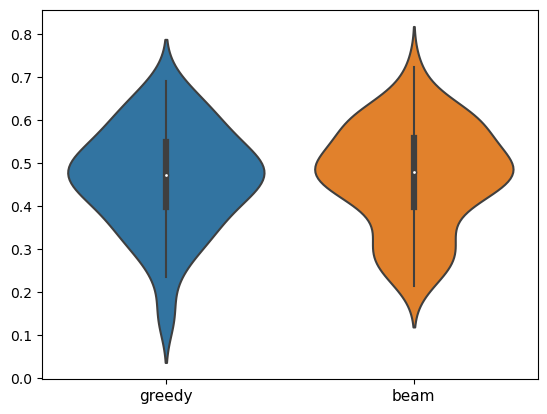

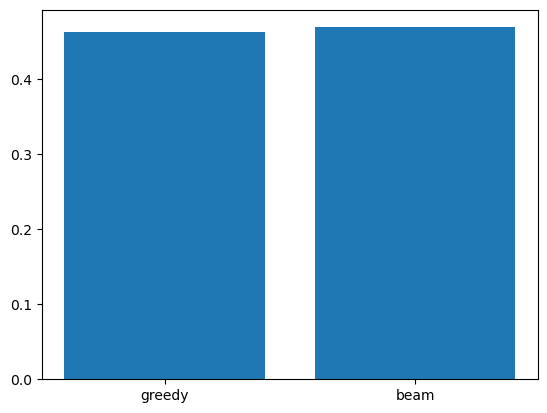

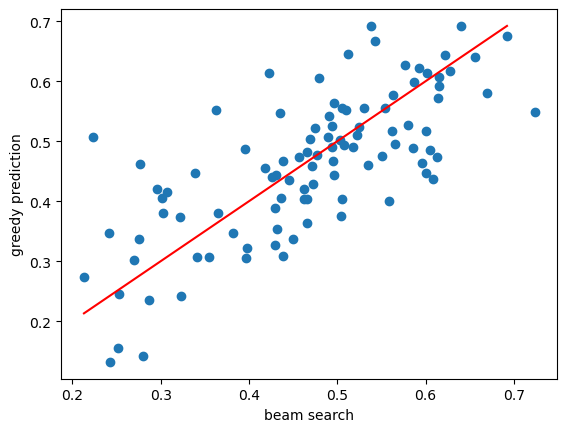

  1%|          | 99/10000 [02:32<4:14:47,  1.54s/it]


In [5]:
plot=False
print_text=False
run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, print_msg=print, num_examples=200, plot=plot, print_text=print_text)

stty: 'standard input': Inappropriate ioctl for device
  0%|          | 0/10000 [00:00<?, ?it/s]

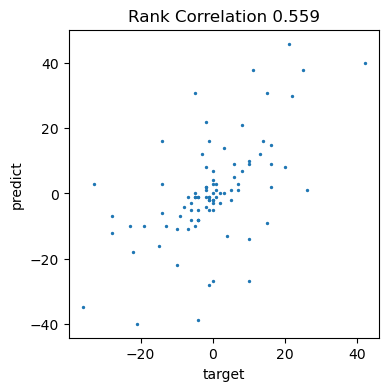

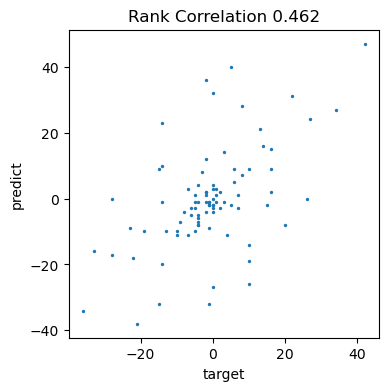

  0%|          | 1/10000 [00:01<4:42:53,  1.70s/it]

--------------------------------------------------------------------------------
            SOURCE: G65 G15 G90 G81 G9 G2 G26 G6 G73 G84 G52 G72 G19 G37 G29 G60 G78 G71 G82 G25 G97 G1 G11 G51 G66 G33 G77 G4 G22 G30 G36 G91 G67 G56 G100 G55 G61 G58 G94 G59 G3 G62 G27 G44 G70 G68 G57 G7 G64 G13 G83 G28 G8 G14 G74 G63 G12 G45 G10 G92 G87 G32 G23 G98 G48 G35 G49 G31 G24 G69 G21 G99 G20 G38 G50 G34 G76 G46 G5 G47 G42 G16 G43 G41 G17 G89 G95 G96 G18 G85 G93 G79 G80 G40 G54 G86 G39 G75 G53 G88
            TARGET: G65 G90 G9 G11 G71 G2 G81 G6 G52 G37 G84 G26 G72 G19 G73 G97 G82 G15 G51 G25 G33 G29 G22 G91 G77 G30 G67 G66 G36 G60 G55 G1 G78 G56 G100 G4 G61 G94 G59 G57 G62 G68 G44 G58 G64 G63 G70 G27 G21 G89 G46 G87 G12 G16 G74 G45 G3 G93 G20 G10 G23 G49 G98 G5 G14 G18 G42 G50 G39 G92 G13 G48 G76 G54 G8 G85 G83 G69 G80 G43 G86 G47 G31 G24 G99 G28 G32 G40 G53 G7 G79 G96 G35 G38 G17 G88 G95 G75 G41 G34
  PREDICTED GREEDY: G65 G90 G6 G81 G26 G37 G9 G71 G2 G52 G84 G19 G11 G73 G72 G29 G15 G25 G78 G8

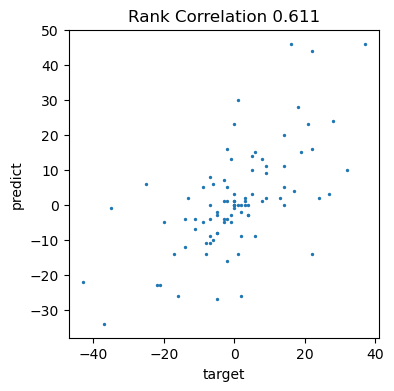

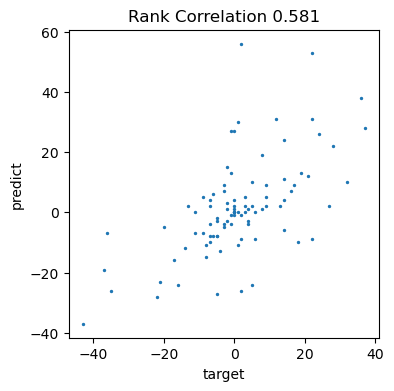

  0%|          | 2/10000 [00:03<4:43:36,  1.70s/it]

--------------------------------------------------------------------------------
            SOURCE: G3 G90 G6 G15 G26 G9 G81 G52 G37 G19 G84 G71 G73 G2 G72 G25 G51 G97 G82 G11 G1 G33 G61 G100 G67 G60 G78 G29 G30 G91 G36 G22 G77 G4 G55 G56 G66 G59 G57 G65 G58 G94 G68 G44 G46 G98 G27 G87 G7 G21 G50 G62 G16 G35 G92 G18 G23 G12 G75 G63 G83 G8 G42 G99 G64 G70 G47 G74 G39 G10 G88 G32 G43 G38 G76 G24 G40 G89 G5 G41 G17 G49 G80 G13 G48 G95 G54 G20 G69 G28 G34 G45 G93 G85 G14 G86 G53 G79 G31 G96
            TARGET: G3 G90 G15 G37 G2 G9 G6 G26 G11 G71 G81 G84 G19 G29 G72 G67 G52 G97 G82 G60 G73 G78 G56 G36 G91 G1 G33 G30 G25 G77 G51 G4 G100 G22 G66 G59 G61 G58 G94 G65 G55 G68 G57 G62 G70 G44 G80 G64 G27 G92 G12 G63 G86 G83 G76 G18 G5 G23 G85 G13 G7 G89 G96 G87 G28 G43 G46 G38 G42 G45 G32 G95 G99 G16 G47 G35 G21 G98 G49 G48 G20 G74 G39 G14 G79 G17 G34 G50 G88 G8 G93 G69 G54 G10 G75 G40 G41 G24 G53 G31
  PREDICTED GREEDY: G3 G90 G6 G81 G26 G37 G9 G71 G2 G52 G84 G19 G11 G73 G72 G29 G15 G25 G78 G82

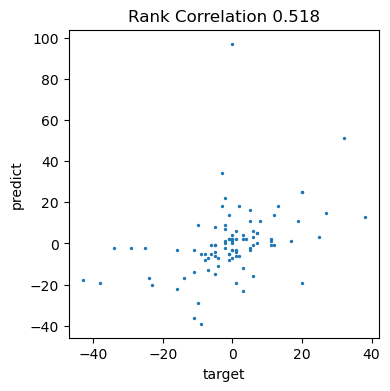

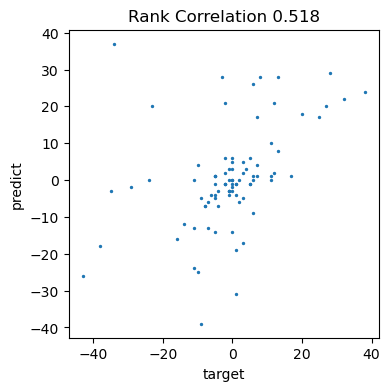

  0%|          | 3/10000 [00:05<4:44:28,  1.71s/it]

--------------------------------------------------------------------------------
            SOURCE: G32 G90 G15 G9 G6 G81 G2 G71 G11 G26 G19 G84 G37 G29 G72 G25 G97 G78 G33 G73 G60 G22 G52 G77 G1 G82 G30 G51 G56 G67 G36 G66 G91 G100 G4 G61 G65 G55 G94 G62 G3 G57 G58 G59 G68 G44 G27 G96 G64 G92 G75 G83 G5 G34 G93 G74 G21 G20 G70 G7 G89 G79 G43 G46 G80 G63 G95 G87 G53 G98 G86 G41 G14 G69 G88 G12 G54 G17 G28 G39 G47 G38 G23 G13 G42 G50 G85 G8 G99 G45 G76 G18 G16 G31 G35 G48 G40 G10 G49 G24
            TARGET: G32 G90 G6 G26 G15 G37 G9 G71 G11 G72 G81 G73 G27 G2 G25 G52 G97 G29 G51 G1 G82 G66 G30 G84 G22 G60 G56 G19 G78 G4 G77 G91 G36 G100 G67 G65 G61 G62 G3 G94 G55 G57 G59 G68 G70 G44 G64 G76 G58 G63 G92 G45 G89 G54 G20 G21 G87 G83 G13 G35 G5 G33 G85 G16 G98 G12 G34 G86 G43 G46 G14 G95 G7 G28 G93 G47 G80 G75 G17 G96 G39 G38 G49 G8 G48 G40 G79 G31 G50 G23 G24 G41 G69 G74 G88 G42 G53 G18 G10 G99
  PREDICTED GREEDY: G32 G90 G6 G81 G26 G37 G2 G9 G71 G52 G84 G19 G11 G72 G73 G29 G78 G25 G97 G3

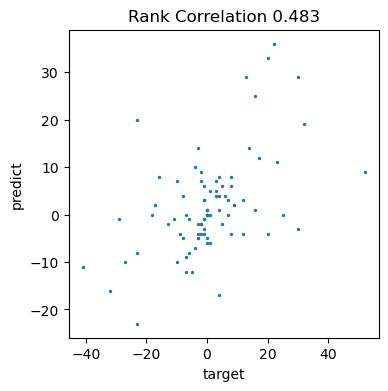

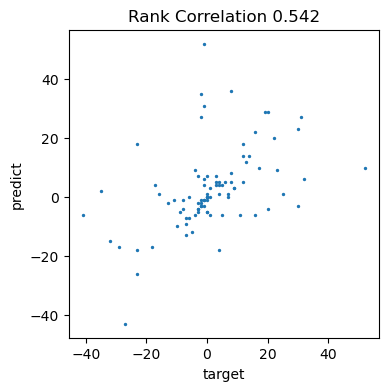

  0%|          | 4/10000 [00:06<4:42:41,  1.70s/it]

--------------------------------------------------------------------------------
            SOURCE: G56 G90 G84 G2 G26 G81 G15 G73 G37 G6 G25 G71 G19 G29 G9 G52 G97 G78 G11 G51 G30 G66 G67 G82 G1 G33 G72 G22 G60 G4 G36 G77 G100 G91 G62 G61 G65 G55 G57 G94 G3 G59 G92 G64 G58 G70 G98 G12 G27 G83 G68 G44 G63 G43 G16 G21 G17 G89 G93 G24 G86 G48 G80 G38 G45 G85 G87 G47 G79 G41 G96 G8 G75 G76 G46 G54 G32 G50 G13 G40 G69 G99 G23 G28 G49 G74 G20 G10 G14 G35 G95 G7 G5 G53 G31 G18 G39 G42 G88 G34
            TARGET: G56 G90 G15 G81 G2 G6 G19 G37 G9 G71 G84 G26 G73 G25 G33 G60 G52 G78 G11 G97 G82 G72 G29 G1 G22 G91 G67 G30 G51 G77 G36 G100 G4 G61 G55 G66 G94 G65 G62 G3 G68 G59 G57 G58 G44 G70 G12 G27 G89 G64 G92 G5 G79 G32 G69 G10 G7 G54 G86 G87 G95 G83 G74 G38 G99 G20 G18 G41 G35 G48 G53 G88 G23 G43 G50 G21 G16 G45 G24 G46 G14 G17 G63 G75 G47 G76 G96 G28 G93 G34 G42 G39 G31 G80 G8 G40 G49 G85 G98 G13
  PREDICTED GREEDY: G56 G90 G6 G81 G26 G37 G9 G71 G2 G52 G84 G19 G11 G73 G72 G29 G15 G25 G78 G8

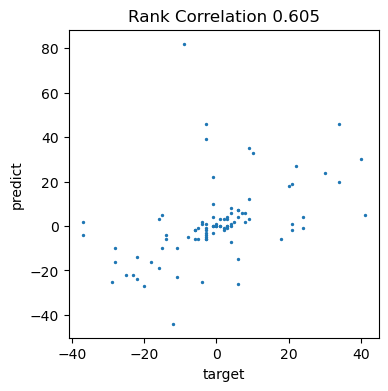

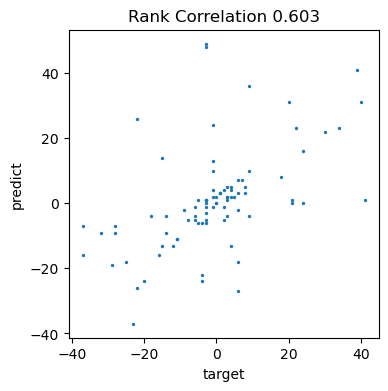

--------------------------------------------------------------------------------
            SOURCE: G90 G81 G26 G71 G9 G37 G2 G84 G6 G72 G52 G22 G11 G78 G15 G82 G19 G33 G30 G36 G29 G25 G1 G73 G55 G97 G51 G91 G67 G60 G56 G66 G61 G77 G100 G4 G65 G94 G62 G57 G68 G58 G59 G44 G70 G27 G64 G43 G38 G92 G49 G21 G83 G85 G89 G93 G79 G50 G20 G53 G40 G95 G80 G63 G74 G34 G98 G54 G18 G12 G46 G5 G3 G16 G7 G47 G69 G42 G87 G45 G8 G96 G24 G17 G13 G41 G99 G35 G88 G32 G10 G14 G76 G75 G23 G86 G39 G31 G28 G48
            TARGET: G90 G2 G26 G6 G52 G81 G71 G19 G73 G9 G22 G72 G78 G25 G11 G84 G82 G29 G15 G77 G51 G33 G97 G55 G30 G60 G36 G67 G1 G37 G91 G100 G61 G65 G94 G66 G57 G4 G56 G62 G44 G68 G27 G70 G12 G38 G92 G63 G89 G64 G3 G59 G32 G96 G21 G98 G46 G43 G99 G39 G31 G45 G54 G79 G75 G8 G28 G18 G88 G40 G76 G24 G86 G83 G87 G14 G93 G50 G23 G95 G7 G53 G58 G42 G49 G74 G10 G48 G13 G17 G35 G16 G69 G85 G41 G34 G80 G20 G5 G47
  PREDICTED GREEDY: G90 G81 G6 G26 G37 G2 G9 G71 G52 G84 G19 G11 G72 G73 G29 G15 G25 G78 G82 G9

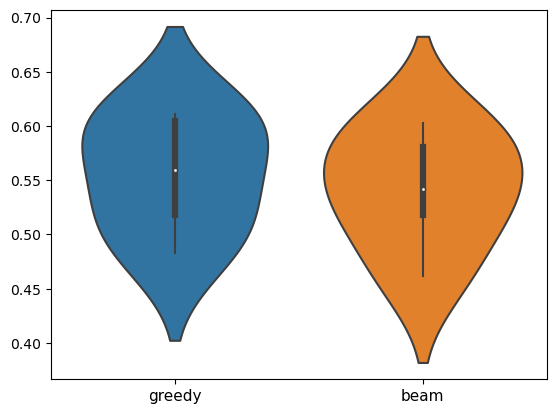

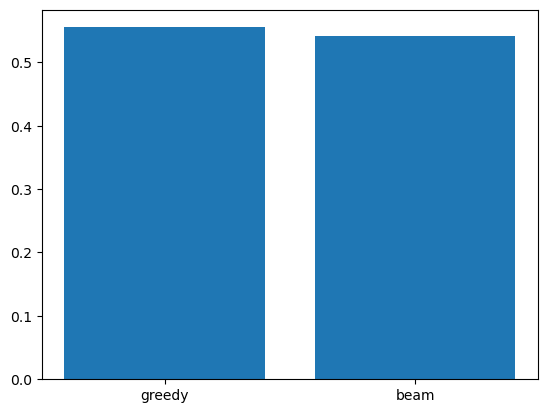

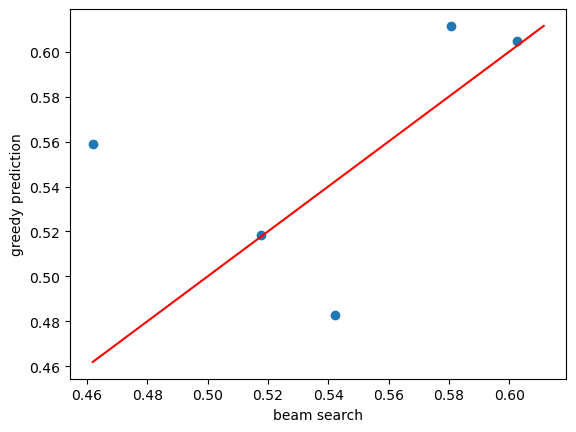

  0%|          | 4/10000 [00:08<6:03:49,  2.18s/it]


In [6]:
plot=True
print_text=True
run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, print_msg=print, num_examples=5, plot=plot, print_text=print_text)